# Homework Set 4

In [1]:
%pylab inline 
import pandas as pd
import numpy as np
import fmt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')


Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


## Problem 1: 

Implement the thomas algorithm for solving tri-diagonal linear systems:

Do your own reading and research on <a href=http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm>Thomas algorithm</a>  and implement and test it in python.

## Solution:
The implementation of the Thomas algorithm is as follows, the performance improvement is impressing.

In [2]:
import copy
from numpy.random import randn

def Thomas(A, d):
    a = np.insert(copy.deepcopy(A[1:, :].diagonal()), 0, 0.)
    b = copy.deepcopy(A.diagonal())
    c = np.append(copy.deepcopy(A[:, 1:].diagonal()), 0.)
    d = copy.deepcopy(d)
    for i in xrange(1, len(A)):
        ai = a[i] / b[i-1]
        b[i] -= ai * c[i-1]
        d[i] -= ai * d[i-1]
    a[-1] = d[-1] / b[-1]
    for j in xrange(len(A)-2, -1, -1):
        a[j] = (d[j] - c[j] * a[j+1]) / b[j]
    return a

Correctness test passed!


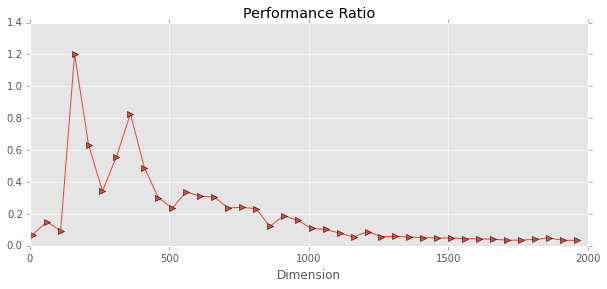

In [3]:
import time
from tqdm import *

def correctness_test(lst):
    dim = np.arange(10, 2000, 50)
    for i in tqdm(dim):
        A = np.zeros((i, i))
        m, l, r = randn(i), randn(i-1), randn(i-1)
        np.fill_diagonal(A, m)
        np.fill_diagonal(A[:,1:], l)
        np.fill_diagonal(A[1:,:], r)
        d = randn(i)
        start1 = time.time()
        res1 = Thomas(A, d)
        end1 = time.time()
        start2 = time.time()
        res2 = np.linalg.solve(A, d)
        end2 = time.time()
        ratio = (end1 - start1) / (end2 - start2)
        lst.append(ratio)
        if not np.allclose(res1, res2):
            print "Different result detected, check your code..."
            return
    print "Correctness test passed!"
    return lst

ratio_list = []
correctness_test(ratio_list)
plt.figure(1, figsize=(10,4))
dim = np.arange(10, 2000, 50)
plt.plot(dim, ratio_list, '->')
plt.title('Performance Ratio')
plt.xlabel("Dimension")
plt.grid(True)
plt.show()

## Problem 2

Given the following benchmark swap quotes for USD, suppose all swap coupons are paid semi-annually:

In [4]:
mats = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25])*1.
par = np.array([.042, .043, .047, .054, .057, .06, .061, .059, .056, .0555])

df_swap = pd.DataFrame(np.array([par]).T*100, columns=["Par Spread (%)"], 
                       index=map(lambda m: '%dY' % m, mats))
fmt.displayDF(df_swap.T, 2, 2)

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Par Spread (%),4.2,4.3,4.7,5.4,5.7,6.0,6.1,5.9,5.6,5.5


1. Explain what is the purpose of the +1e-6 in the first line of the priceSwap function
2. Use the market data above to boostrap the IR curve by interpolating the cumulative yield $y(t) = -\log(b(t))$ with tension spline, where $b(t)$ is the discount factor (i.e., the price of risk free zero coupon bonds). After bootstraping the curve, re-price the benchmark instruments using the bootstrapped curve, and compute the L-2 norm of the absolute pricing errors. Show how the pricing error of the bootstraped curve depend on the tension parameter $\lambda$.
3. Using the iteration technique to reduce the L-2 norm of the error below 1bps, how many iteration is needed for the error to go below 1bps?
4. From the curve built in the previous step, compute both the $y(t)$ and the instantaneous forward rate $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} = \frac{d y(t)}{dt}$, and show how their shapes change with the tension parameter $\lambda$. In addition, compare the changes in the instantaneous forward rates with 1bps change in the 5Y par swap rate. You can use the deriv() method in the Tension spline class. 
6. Repeat the previous step, but directly interpolating the forward rates $f(t)$, and comment on whether it is suitable in practice.
5. [extra credit] Build the curve by interpolating the zero rate with tension spline instead, i.e, $r(t) = \frac{y(t)}{t}$, compare how the forward rates shape and perturbations differ from those obtained in step 4, and comment on the pro and cons between interpolating $r(t)$ and $y(t)$.
7. [extra credit] write your own bootstrap function instead of calling those provided by the class library

Hint: 
* write your code in a modular and reusable way; you can re-use the code provided as part of the class lecture, but you get extra credit if you can write your own bootstraping. The source code of the inst package is hidden from you, but you can figure out how to use them by reading their docstring with help(), please use the python codes in the lecture slides as examples.
* be careful with the choice of boundary for the root search, allow negative rates often helps stablizing the bootstraping, even though it does not make economic sense
* in step 5, you may have to mix the old and new results to stablize the iteration, (e.g., use mixf=0.5 in the inst.iterboot function, or your own)

## Solution:
#### 1.
Since np.arange can take floating increment, +1e-6 here is to guarantee the last value of the array can be achieved. Otherwise the error resulted by floating point may lead to the imprecise of the array shape. Example:

In [5]:
a = np.arange(0.1, 25, 0.1)
b = np.arange(0.1, 25 + 1e-6, 0.1)
print len(a), len(b)

249 250


#### 2.
I tried to write the bootstrap myself, however, mine got some problems that seems unstable, so I will use the inst.iterboot() from the lecture.

The pricing errors are shown below, we can see that the error decreases as the $\lambda$ increases.

In [6]:
import inst
import lin
import pandas as pd
from swap import Swap, priceSwap

def y2pv(swap, curve) :
    discf = lambda ts: np.exp(-curve(ts))
    return priceSwap(swap, discf)
def bootstrap(bms, pfunc, x0, lbds, bds, its, mixf = 0.):
    new_c = []
    error = []
    for i in lbds:  
        n_c, err = inst.iterboot(bms, pfunc, x0, i, bds, its, mixf)
        error += [err[-1]]
        new_c.append(n_c)
    return new_c, error

mats = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25])*1.
par = np.array([.042, .043, .047, .054, .057, .06, .061, .059, .056, .0555])
bm_swaps = {Swap(m, c, 2) : 0 for m, c in zip (mats, par)}
lbds = [0, 2, 10, 50]
curve_tags = ['%d Y' % l for l in mats]

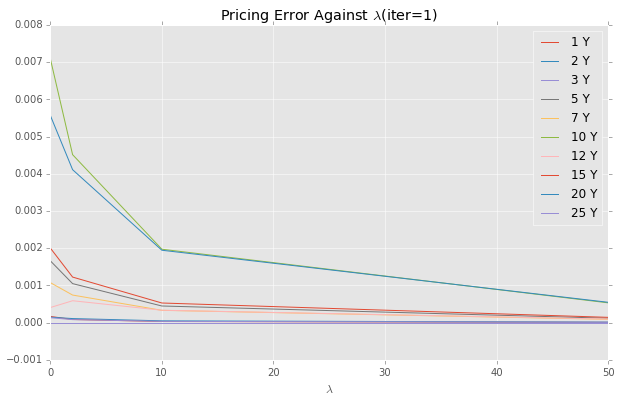

In [7]:
cvs, err = bootstrap(bm_swaps, y2pv, 0, lbds, [-2, 2], 1)
df = pd.DataFrame(err, columns=curve_tags, index=lbds)
df.plot(figsize=(10, 6), xlim=[0,50])
plt.xlabel(r"$\lambda $")
plt.title("Pricing Error Against $\lambda$(iter=1)")

#### 3.
By increasing the iterations to 2, the error will go below 1bps.

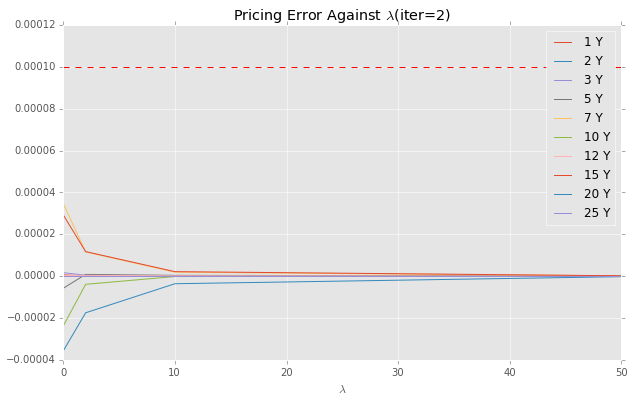

In [8]:
cvs, err = bootstrap(bm_swaps, y2pv, 0, lbds, [-2, 2], 2)
df = pd.DataFrame(err, columns=curve_tags, index=lbds)
df.plot(figsize=(10, 6), xlim=[0,50])
plt.xlabel(r"$\lambda $")
plt.title("Pricing Error Against $\lambda$(iter=2)")
plt.legend(loc='best')
plt.axhline(0.0001, color='r', label="1bps", linestyle='--')

#### 4.
Their shapes' changes with the tension parameter $\lambda$ are shown below:

In [9]:
lbds = [0, 2, 10, 50]
lbdTags = ['$\lambda$=%d' % l for l in lbds]
t = np.arange(0.1, 25 + 1e-6, 0.1)

par_pert = par
par_pert[3] += 0.0001
bm_ps = {Swap(m, c, 2) : 0 for m, c in zip (mats, par_pert)}
cvs, e1 = bootstrap(bm_swaps, y2pv, 0, lbds, [-2, 2], 2)
cvs_pert, e2 = bootstrap(bm_ps, y2pv, 0, lbds, [-2, 2], 2)

r1, r1_term = np.zeros((len(cvs), len(t))), np.zeros((len(cvs), len(mats)))
r2, r2_term = np.zeros((len(cvs), len(t))), np.zeros((len(cvs), len(mats)))
for i in xrange(len(cvs)):
    a = cvs[i]
    r1[i] = a.deriv(t)
    r2[i] = cvs[i].deriv(t) - cvs_pert[i].deriv(t)
for i in xrange(len(cvs)):
    r1_term[i] = cvs[i].deriv(mats)
    r2_term[i] = cvs[i].deriv(mats) - cvs_pert[i].deriv(mats)

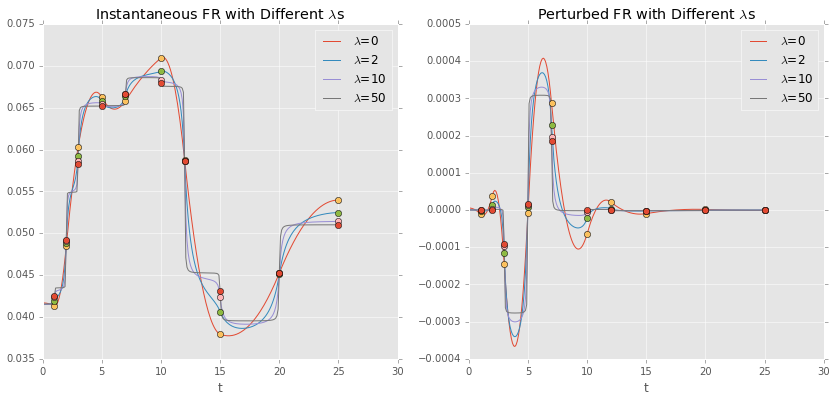

In [10]:
figure(figsize=(14, 6))

subplot(1, 2, 1)
plot(t, r1.T)
plot(mats, r1_term.T, 'o')
title('Instantaneous FR with Different $\lambda$s')
xlabel('t')
legend(lbdTags, loc='best')

subplot(1, 2, 2)
plot(t, r2.T)
plot(mats, r2_term.T, 'o')
title('Perturbed FR with Different $\lambda$s')
xlabel('t')
legend(lbdTags, loc='best')

#### 5.
We can see that directly interpolating the forward rates $f(t)$ is a poor choice. Very unstable.

In [11]:
def hazard_pv_1(swap, curve) :
    discf = inst.fwd2disc(curve)
    return priceSwap(swap, discf)

cvs_1, e1 = bootstrap(bm_swaps, hazard_pv_1, 0.035, lbds, [-1, 1], 2, mixf = 0.5)
cvs_pert_1, e2 = bootstrap(bm_ps, hazard_pv_1, 0.035, lbds, [-1, 1], 2, mixf = 0.5)

r1, r1_term = np.zeros((len(cvs_1), len(t))), np.zeros((len(cvs_1), len(mats)))
r2, r2_term = np.zeros((len(cvs_1), len(t))), np.zeros((len(cvs_1), len(mats)))
for i in xrange(len(cvs_1)):
    r1[i] = cvs_1[i].deriv(t)
    r2[i] = cvs_1[i].deriv(t) - cvs_pert_1[i].deriv(t)
for i in xrange(len(cvs_1)):
    r1_term[i] = cvs_1[i].deriv(mats)
    r2_term[i] = cvs_1[i].deriv(mats) - cvs_pert_1[i].deriv(mats)

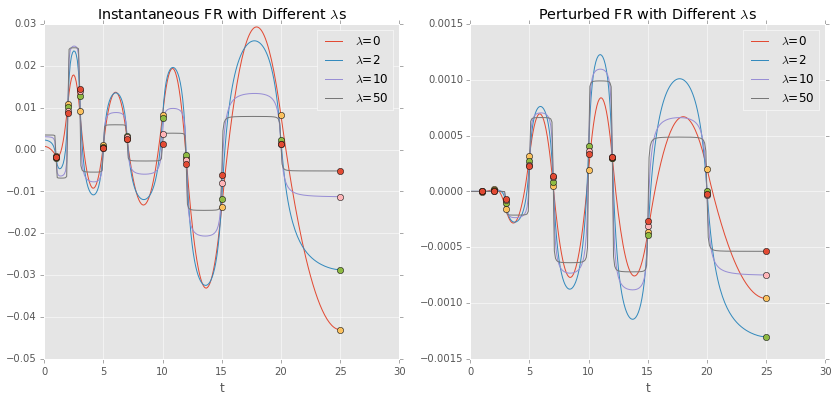

In [12]:
figure(figsize=(14, 6))

subplot(1, 2, 1)
plot(t, r1.T)
plot(mats, r1_term.T, 'o')
title('Instantaneous FR with Different $\lambda$s')
xlabel('t')
legend(lbdTags, loc='best')

subplot(1, 2, 2)
plot(t, r2.T)
plot(mats, r2_term.T, 'o')
title('Perturbed FR with Different $\lambda$s')
xlabel('t')
legend(lbdTags, loc='best')

#### 6.
Interpolating the zero rate, i.e, $r(t) = \frac{y(t)}{t}$ is also a good choice(even more stable than $y(t)$). The plots are shown below. I think the cons is that the curve shape is somehow counterintuitive with the real world.

In [13]:
def hazard_pv_2(swap, curve) :
    discf = lambda t : np.exp(-t * curve(t))
    return priceSwap(swap, discf)


cvs_2, e1 = bootstrap(bm_swaps, hazard_pv_2, 0.05, lbds, [-.5, .5], 2)
cvs_pert_2, e2 = bootstrap(bm_ps, hazard_pv_2, 0.05, lbds, [-.5, .5], 2)

r1, r1_term = np.zeros((len(cvs_2), len(t))), np.zeros((len(cvs_2), len(mats)))
r2, r2_term = np.zeros((len(cvs_2), len(t))), np.zeros((len(cvs_2), len(mats)))
for i in xrange(len(cvs_2)):
    r1[i] = cvs_2[i].deriv(t)
    r2[i] = cvs_2[i].deriv(t) - cvs_pert_2[i].deriv(t)
for i in xrange(len(cvs_1)):
    r1_term[i] = cvs_2[i].deriv(mats)
    r2_term[i] = cvs_2[i].deriv(mats) - cvs_pert_2[i].deriv(mats)

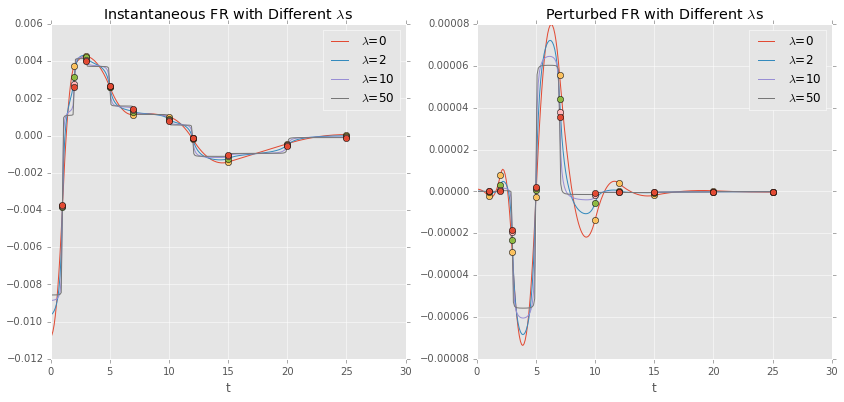

In [14]:
figure(figsize=(14, 6))

subplot(1, 2, 1)
plot(t, r1.T)
plot(mats, r1_term.T, 'o')
title('Instantaneous FR with Different $\lambda$s')
xlabel('t')
legend(lbdTags, loc='best')

subplot(1, 2, 2)
plot(t, r2.T)
plot(mats, r2_term.T, 'o')
title('Perturbed FR with Different $\lambda$s')
xlabel('t')
legend(lbdTags, loc='best')

#### 7.
[extra credit] write your own bootstrap function instead of calling those provided by the class library